In [1]:
import csv
import os

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Conv1D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf

# 1. Utworzenie zbioru treningowego i testowego

## 1.1 Otwarcie pliku

In [2]:
with open('data_new.csv', newline='') as f:
    reader = csv.reader(f)
    data_temp = list(reader)
data_temp.pop(0)
print(data_temp[:10])

[['0_417', '0', '417', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_418', '0', '418', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_419', '0', '419', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_420', '0', '420', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_421', '0', '421', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_422', '0', '422', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_423', '0', '423', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_424', '0', '424', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_426', '0', '426', '-0.32626265124330317', '0.0', 'False', 'False'], ['0_427', '0', '427', '-0.32626265124330317', '0.0', 'False', 'False']]


In [3]:
data = []
true = false = 0
for x in data_temp:
    if x[6] == 'True':
        true += 1
    else:
        false += 1
    data.append([x[0], float(x[3]), float(x[4]), x[5] == 'True', x[6] == 'True'])
print(data[0], true, false)

['0_417', -0.32626265124330317, 0.0, False, False] 3610 10480


## 1.2 Obliczenie rozmiaru

In [4]:
# train_count = int(len(data) * 0.8)
# test_count = len(data) - train_count
# print(train_count + test_count, len(data))
# assert train_count + test_count == len(data)

frame_size = 5

## 1.3 Utworzenie zbioru

Dla każdego Y dodawane jest do X frame_size wartości sensora przed

In [5]:
X_train_min_max = []
X_train_z_score = []
Y_train = []
X_test_min_max = []
X_test_z_score = []
Y_test = []

train_images = os.listdir('dataset/train/true')
train_images = [x.split('.')[0].split('_') for x in train_images]
train_images = [[int(x[0]), int(x[1])] for x in train_images]
test_images = os.listdir('dataset/test/true')
test_images = [x.split('.')[0].split('_') for x in test_images]
test_images = [[int(x[0]), int(x[1])] for x in test_images]

frame_length = frame_size - 1
sensor_values_min_max = []
sensor_values_z_score = []


for i in range(len(data)):
    video_id = int(data[i][0].split('_')[0])
    frame_id = int(data[i][0].split('_')[1])
    ground_truth = data[i][4]


    if video_id >= 2:
        print(video_id, frame_id)
        break

    sensor_values_min_max = [data[j][2] for j in range(i - frame_length, i + 1)]
    sensor_values_z_score = [data[j][1] for j in range(i - frame_length, i + 1)]
    if [video_id, frame_id] in train_images:
        Y_train.append(ground_truth)
        X_train_min_max.append(sensor_values_min_max)
        X_train_z_score.append(sensor_values_z_score)
    else:
        Y_test.append(ground_truth)
        X_test_min_max.append(sensor_values_min_max)
        X_test_z_score.append(sensor_values_z_score)

    # if i % frame_size == 0 and i != 0:
    #     if [video_id, frame_id] in train_images:
    #         Y_train.append(ground_truth)
    #         X_train_min_max.append(sensor_values_min_max)
    #         X_train_z_score.append(sensor_values_z_score)
    #     else:
    #         Y_test.append(ground_truth)
    #         X_test_min_max.append(sensor_values_min_max)
    #         X_test_z_score.append(sensor_values_z_score)
    #     sensor_values_min_max = []
    #     sensor_values_z_score = []
    #
    # sensor_values_min_max.append(data[i][2])
    # sensor_values_z_score.append(data[i][1])

print(len(Y_train), len(Y_test))

X_train_min_max = np.array(X_train_min_max)
X_train_z_score = np.array(X_train_z_score)
Y_train = np.array(Y_train)
print(X_test_min_max[1])
X_test_min_max = np.array(X_test_min_max)
X_test_z_score = np.array(X_test_z_score)
Y_test = np.array(Y_test)

2 1
1159 4061
[0.2923076923076923, 0.3076923076923077, 0.2769230769230769, 0.0, 0.0]


In [6]:
data_np = np.array(data)

filter_false = data_np[:, 4] == 'True'
# data_true = data_np[filter_true][:,2]
# data_false = data_np[filter_false][:,2]
print(print(data_np[0]))

['0_417' '-0.32626265124330317' '0.0' 'False' 'False']
None


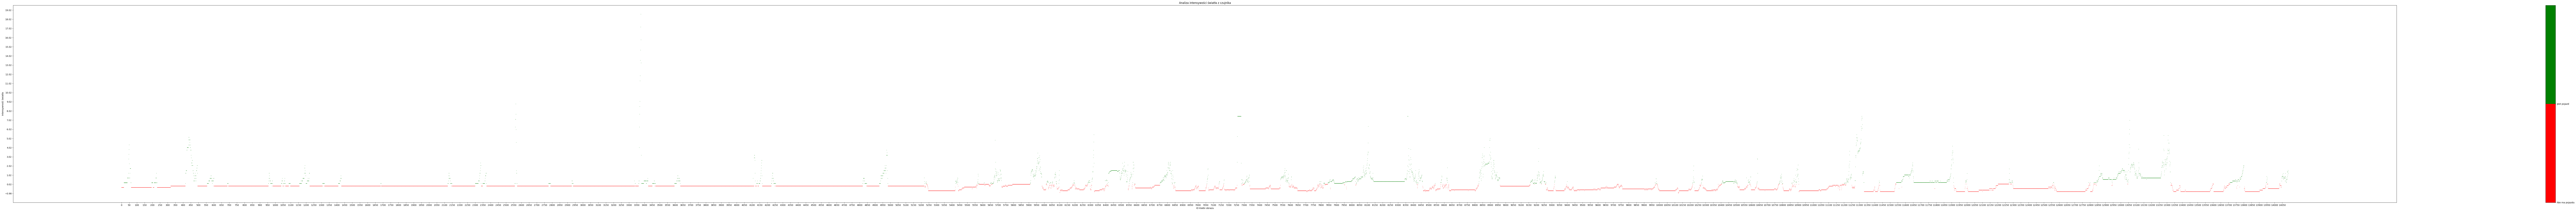

In [7]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib


x = range(len(data_np[:,2]))
y = data_np[:,1].astype(float)
label = data_np[:, 4] == 'True'
colors = ['red','green']

fig = plt.figure(figsize=(240,16))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), s=0.2)

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))

cb.set_ticks(loc)
cb.set_ticklabels(['Nie ma pojazdu', 'Jest pojazd'])

plt.xlabel("ID klatki obrazu")
plt.ylabel("Intensywność światła")
plt.xticks(np.arange(min(x), max(x)+1, 50.0))
plt.yticks(np.arange(min(y), max(y)+1, 1.0))
plt.title('Analiza intensywości światła z czujnika')
plt.show()

In [9]:
from PIL import Image, ImageOps

for i, x in enumerate(data):
    print(x)
    break
selected_data = data[3480]
filename = f"{selected_data[0]}.jpg"
img = Image.open(f'dataset/false/{filename}')
img = ImageOps.invert(img)
plt.imshow(img)


    # ground_truth = data[i][4]

['0_417', -0.32626265124330317, 0.0, False, False]


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/false/1_3926.jpg'

## Definicja modelu

In [17]:
model = Sequential()
# model.add(Dense(25,activation='relu'))

model.add(LSTM(8, input_shape=(frame_size, 1)))

# model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.build(input_shape=(frame_size, 1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train_z_score, Y_train, epochs=10)

Epoch 1/10
37/37 [==============================] - 3s 35ms/step - loss: 0.6311 - binary_accuracy: 0.9543 - precision_2: 0.9606 - recall_2: 0.7176
Epoch 2/10
37/37 [==============================] - 1s 28ms/step - loss: 0.5215 - binary_accuracy: 0.9396 - precision_2: 0.9386 - recall_2: 0.6294
Epoch 3/10
37/37 [==============================] - 1s 24ms/step - loss: 0.3618 - binary_accuracy: 0.9387 - precision_2: 0.9381 - recall_2: 0.6235
Epoch 4/10
37/37 [==============================] - 2s 43ms/step - loss: 0.2320 - binary_accuracy: 0.9370 - precision_2: 0.9292 - recall_2: 0.6176
Epoch 5/10
37/37 [==============================] - 3s 78ms/step - loss: 0.1957 - binary_accuracy: 0.9370 - precision_2: 0.9292 - recall_2: 0.6176
Epoch 6/10
37/37 [==============================] - 4s 109ms/step - loss: 0.1766 - binary_accuracy: 0.9370 - precision_2: 0.9217 - recall_2: 0.6235
Epoch 7/10
37/37 [==============================] - 3s 83ms/step - loss: 0.1556 - binary_accuracy: 0.9379 - precision

In [19]:
model.evaluate(X_test_z_score, Y_test)

127/127 [==============================] - 8s 62ms/step - loss: 0.1058 - binary_accuracy: 0.9663 - precision_2: 0.8925 - recall_2: 0.8729


[0.10575208812952042,
 0.9662644863128662,
 0.8925476670265198,
 0.8728813529014587]

In [47]:
model2 = Sequential()
model2.add(Conv1D(8, 1, input_shape=(frame_size, 1)))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam',
               metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [48]:
model2.fit(X_train_min_max, Y_train,  epochs=5)

Epoch 1/5
37/37 [==============================] - 3s 57ms/step - loss: 0.6677 - binary_accuracy: 0.9077 - precision_13: 0.7333 - recall_13: 0.5824
Epoch 2/5
37/37 [==============================] - 2s 58ms/step - loss: 0.5709 - binary_accuracy: 0.8921 - precision_13: 0.9787 - recall_13: 0.2706
Epoch 3/5
37/37 [==============================] - 2s 57ms/step - loss: 0.4053 - binary_accuracy: 0.8714 - precision_13: 1.0000 - recall_13: 0.1235
Epoch 4/5
37/37 [==============================] - 2s 57ms/step - loss: 0.3427 - binary_accuracy: 0.8758 - precision_13: 1.0000 - recall_13: 0.1529
Epoch 5/5
37/37 [==============================] - 2s 57ms/step - loss: 0.3201 - binary_accuracy: 0.8835 - precision_13: 1.0000 - recall_13: 0.2059


In [49]:
model2.evaluate(X_test_z_score, Y_test)


127/127 [==============================] - 4s 33ms/step - loss: 0.1511 - binary_accuracy: 0.9682 - precision_13: 0.9374 - recall_13: 0.8373


[0.15108807384967804,
 0.9682344198226929,
 0.937381386756897,
 0.8372881412506104]